#### Autoencoder Learning Experiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import calendar;
import time; # Importing necessary libraries
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# import seaborn as sns

from src.linear_ae_net.dynamics import *

## Generate Dataset and define model

In [2]:
def generate_gmm_data(d, n_components=4, random_state=42, num_data=1000, 
                            means=None, vars=None, sizes=None, tags=None):
    """
    Generate a GMM dataset with exact cluster sizes and custom string labels.

    - sizes: list of exact number of samples for each component; sum(sizes) == num_data
    - tags: list of string labels for each component

    Returns:
    - X: (num_data, d)
    - labels: (num_data,) array of strings (from tags)
    """
    rng = np.random.default_rng(random_state)

    if sizes is None:
        sizes = [num_data // n_components] * n_components
        sizes[-1] += num_data - sum(sizes)
    else:
        sizes = list(sizes)
        assert len(sizes) == n_components, "Sizes must match the number of components"
        num_data = sum(sizes)   # adjust num_data to match sizes

    if tags is None:
        tags = [str(i) for i in range(n_components)]
    else:
        assert len(tags) == n_components

    if means is None:
        means = rng.uniform(-20, 20, size=(n_components, d))
    else:
        means = np.array(means, dtype=float)
        assert means.shape == (n_components, d)

    if vars is None:
        covariances = [np.diag(rng.uniform(0.1, 0.2, size=d)) for _ in range(n_components)]
    else:
        covariances = [np.diag([var]*d) for var in vars]

    X = []
    labels = []
    for k in range(n_components):
        Xk = rng.multivariate_normal(means[k], covariances[k], size=sizes[k])
        X.append(Xk)
        labels.extend([tags[k]] * sizes[k])
    X = np.vstack(X)
    labels = np.array(labels)
    perm = rng.permutation(num_data)
    return X[perm], labels[perm]

def zscore_normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)

In [3]:
def plot_2d_projection_with_principal_axes(X, labels, dim_x=0, dim_y=1, label_names=None):
    """
    X: (N, d) array (d >= 2)
    labels: length-N int or string labels
    dim_x, dim_y: which dimensions to plot (0-based)
    label_names: list of label strings, or None to skip legend
    """
    # Map string labels to numeric for color
    label_names_unique, labels_numeric = np.unique(labels, return_inverse=True)
    
    # Compute mean and covariance in full space
    mu = X.mean(axis=0)
    C = np.cov(X, rowvar=False)
    U, S, Vt = np.linalg.svd(C)

    # 2D mean for plot
    mu2 = mu[[dim_x, dim_y]]

    plt.figure(figsize=(7, 7))
    # Scatterplot of projection
    plt.scatter(X[:, dim_x], X[:, dim_y], c=labels_numeric, alpha=0.6, cmap='tab10', label='')

    # Draw and label first two principal axes, projected
    for i in range(3):
        vec = U[:, i] * np.sqrt(S[i])
        vec2 = vec[[dim_x, dim_y]]
        plt.arrow(mu2[0], mu2[1], vec2[0], vec2[1], width=0.05, length_includes_head=True, label=f'σ{i+1}')
        plt.arrow(mu2[0], mu2[1], -vec2[0], -vec2[1], width=0.05, length_includes_head=True)
        plt.text(mu2[0] + vec2[0]*1.1, mu2[1] + vec2[1]*1.1, f'({i}){S[i]:.2f}', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.xlabel(f"Dimension {dim_x+1}")
    plt.ylabel(f"Dimension {dim_y+1}")
    plt.title("GMM Samples: Principal Axes & Singular Values (Projected)")
    plt.grid(True)

    # Legend with class names, if available
    if label_names is not None:
        for i, name in enumerate(label_names_unique):
            plt.scatter([], [], c=[plt.cm.tab10(i)], label=name)
        plt.legend(title="Class")

    plt.show()

    # 1) Covariance matrix heatmap
    C = np.cov(X, rowvar=False)
    plt.figure()
    plt.imshow(C, aspect='equal')
    plt.colorbar()
    plt.title("Covariance Matrix")
    plt.xlabel("Dimension")
    plt.ylabel("Dimension")
    plt.show()

    # 2) Singular values
    U, S, Vt = np.linalg.svd(C)
    plt.figure()
    plt.bar(np.arange(1, len(S)+1), S)
    plt.xlabel("Component")
    plt.ylabel("Singular Value")
    plt.title("Singular Values of Covariance Matrix")
    plt.show()


def plot_2d_projection_with_principal_axes_2(X, labels, dim_x=0, dim_y=1, label_names=None):
    """
    X: (N, d) array (d >= 2)
    labels: length-N int or string labels
    dim_x, dim_y: which dimensions to plot (0-based)
    label_names: list of label strings, or None to skip legend
    """
    # Map string labels to numeric for color
    label_names_unique, labels_numeric = np.unique(labels, return_inverse=True)
    
    # Compute mean and covariance in full space
    mu = X.mean(axis=0)
    # C = np.cov(X, rowvar=False)
    C = compute_correlation_matrix(X, X)
    U, S, Vt = np.linalg.svd(C)

    # 2D mean for plot
    mu2 = mu[[dim_x, dim_y]]

    plt.figure(figsize=(7, 7))
    # Scatterplot of projection
    plt.scatter(X[:, dim_x], X[:, dim_y], c=labels_numeric, alpha=0.6, cmap='tab10', label='')

    # Draw and label first two principal axes, projected
    for i in range(4):
        vec = U[:, i] * np.sqrt(S[i])
        vec2 = vec[[dim_x, dim_y]]
        plt.arrow(mu2[0], mu2[1], vec2[0], vec2[1], width=0.05, length_includes_head=True, label=f'σ{i+1}')
        plt.arrow(mu2[0], mu2[1], -vec2[0], -vec2[1], width=0.05, length_includes_head=True)
        plt.text(mu2[0] + vec2[0]*1.1, mu2[1] + vec2[1]*1.1, f'{S[i]:.2f}', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.xlabel(f"Dimension {dim_x+1}")
    plt.ylabel(f"Dimension {dim_y+1}")
    plt.title("GMM Samples: Principal Axes & Singular Values (Projected)")
    plt.grid(True)

    # Legend with class names, if available
    if label_names is not None:
        for i, name in enumerate(label_names_unique):
            plt.scatter([], [], c=[plt.cm.tab10(i)], label=name)
        plt.legend(title="Class")

    plt.show()

    # 1) Covariance matrix heatmap
    # C = np.cov(X, rowvar=False)
    C = compute_correlation_matrix(X, X)
    plt.figure()
    plt.imshow(C, aspect='equal')
    plt.colorbar()
    plt.title("Covariance Matrix")
    plt.xlabel("Dimension")
    plt.ylabel("Dimension")
    plt.show()

    # 2) Singular values
    U, S, Vt = np.linalg.svd(C)
    plt.figure()
    plt.bar(np.arange(1, len(S)+1), S)
    plt.xlabel("Component")
    plt.ylabel("Singular Value")
    plt.title("Singular Values of Covariance Matrix")
    plt.show()

In [4]:
class LinearAutoEncoder():
    '''Neural network class'''
    def __init__(self):
        self.history = {'loss': [], 'val_loss': [], 'weights': {'W1':[], 'W2':[]}, 'activations': [], 'testing_activations': [], 'z_testing_activations': []}
    
    def train(self, X, X_val=None, input_dim=5, n_epoch=100, hidden_dim=100, learning_rate=0.1, reg_param=0.0001, 
              noise='gaussian', noise_scale=1, verbose=False, Y=None, Y_val=None, Z=None, Z_val=None):
        """
        Y: testing data
        """
        self.y_val = Y_val
        dtype = torch.cuda.FloatTensor
        X_in = X.clone().type(dtype)
        X = X.type(dtype)
        N = X.shape[0]
        D = X.shape[1]
        
        self.strenghts = torch.zeros((1, D)).type(dtype)
        self.W1 = 0.0001*torch.randn(X.shape[1], hidden_dim).type(dtype)
        self.W2 = 0.0001*torch.randn(hidden_dim, input_dim).type(dtype)

        W = self.W1.mm(self.W2)
        s_int = np.linalg.svd(W.cpu().numpy(), compute_uv=0)
        self.init = np.sum(s_int[:100])/len(s_int)

        corr_mat = compute_correlation_matrix(X.cpu().numpy(), X.cpu().numpy())
        self.U, self.S, self.Vt = np.linalg.svd(corr_mat)

        UZ = torch.from_numpy((Z.cpu().numpy() @ self.U)) if Z is not None else None
        
        for t in range(n_epoch):
            
            W1 = self.W1
            W2 = self.W2
            
            # compute scores
            h1 = X_in.mm(W1)
            scores = h1.mm(W2)

            # compute loss
            data_loss = 0.5*((scores - X).pow(2).sum())/N
            noise_loss = 0.5*noise_scale*torch.trace(W2.t().mm(W1.t()).mm(W1).mm(W2))
            reg_loss = 0.5*reg_param*torch.sum(W1*W1) + 0.5*reg_param*torch.sum(W2*W2)
            loss = data_loss + noise_loss + reg_loss
                    
            # store loss
            self.history['loss'].append(loss)
        
            # compute the gradient using backpropagation
            dscores = (scores - X)/N
            dW2 = h1.t().mm(dscores)
            dhidden = dscores.mm(W2.t())
            dW1 = X_in.t().mm(dhidden)
            
            # add regularisation gradients
            dW2 += reg_param*W2
            dW1 += reg_param*W1
            
            # add noise gradients
            dW1 += noise_scale*W1.mm(W2).mm(W2.t())
            dW2 += noise_scale*W1.t().mm(W1).mm(W2)

            # perform parameter updates
            self.W1 += -learning_rate*dW1
            self.W2 += -learning_rate*dW2
            
            # compute validation loss
            if X_val is not None:
                val_pred = self.predict(X_val)
                val_loss = 0.5*(X_val - val_pred).pow(2).sum()/N
                self.history['val_loss'].append(val_loss)
                if verbose:
                    if t % 100 == 0:
                        print('iteration: ', t, 'training loss: ', loss, ' validation loss: ', val_loss)
            else:
                if verbose:
                    if t % 100 == 0:
                        print('iteration: ', t, 'training loss: ', loss)
            
            # compute eigenvalues
            if t % 10 == 0:
                W = self.W1.mm(self.W2)
                # W = self.W1
                s = np.linalg.svd(W.cpu().numpy(), compute_uv=0)
                s = torch.unsqueeze(torch.from_numpy(s).type(dtype), 1).t()
                self.strenghts = torch.cat((self.strenghts, s), dim=0)

                testing_activations = self.encode(Y.type(dtype))
                z_testing_activations = self.encode(UZ.type(dtype)) if Z is not None else 0.0
                
                self.history['weights']['W1'].append(W1.cpu().numpy().copy())
                self.history['weights']['W2'].append(W2.cpu().numpy().copy())
                self.history['activations'].append(h1.cpu().numpy().copy())
                self.history['testing_activations'].append(testing_activations.cpu().numpy().copy())
                self.history['z_testing_activations'].append(z_testing_activations.cpu().numpy().copy())
        
    def predict(self, X):
        W1 = self.W1
        W2 = self.W2
        h1 = X.type(torch.cuda.FloatTensor).mm(W1)
        scores = h1.mm(W2)
        return scores
    
    def encode(self, X):
        W1 = self.W1
        W2 = self.W2
        h1 = X.type(torch.cuda.FloatTensor).mm(W1)
        # scores = h1.mm(W2)
        return h1

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tokens_2d(data_test, label_test, dim_x=0, dim_y=1, figsize=(6,6), alpha=0.7, selected_labels=None):
    """
    2-D scatter plot of selected dimensions of data_test, colored by label_test.

    Parameters
    ----------
    data_test : array-like, shape (N, D)
        Test data matrix.
    label_test : array-like, shape (N,)
        Labels or token types corresponding to each data point.
    dim_x : int
        Index of the feature to use for the x-axis.
    dim_y : int
        Index of the feature to use for the y-axis.
    figsize : tuple
        Figure size.
    alpha : float
        Point transparency.
    """
    data_test = np.asarray(data_test)
    label_test = np.asarray(label_test)

    # Unique labels
    labels = np.unique(label_test)
    plt.figure(figsize=figsize)

    for lab in labels:
        mask = label_test == lab
        plt.scatter(
            data_test[mask, dim_x],
            data_test[mask, dim_y],
            label=str(lab),
            alpha=alpha
        )

    plt.xlabel(f"Dimension {dim_x}")
    plt.ylabel(f"Dimension {dim_y}")
    plt.title(f"2D plot: dim {dim_x} vs dim {dim_y}")
    plt.legend(title="Tokens", loc="best", fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def select_tokens(data, labels, target_tokens):
    data = np.asarray(data)
    labels = np.asarray(labels)

    mask = np.isin(labels, target_tokens)
    data_selected = data[mask]
    labels_selected = labels[mask]

    return data_selected, labels_selected, mask

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_with_ellipses(X, y, dims=(0, 1), ax=None, colors=None, alpha=0.15):
    """
    Plot datapoints projected onto selected dimensions and draw 1-SD ellipses for each category.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix.
    y : array-like, shape (n_samples,)
        Labels for each datapoint (e.g., vowel categories).
    dims : tuple of int
        Indices of two dimensions to plot, e.g., (0, 1) or (1, 2).
    ax : matplotlib Axes, optional
        Axis to plot on. Creates a new one if None.
    colors : dict or list, optional
        Colors for each unique label. If None, uses default colormap.
    alpha : float, optional
        Transparency level for the ellipses.
    """
    import matplotlib.cm as cm

    X = np.asarray(X)
    y = np.asarray(y)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    labels = np.unique(y)
    cmap = cm.get_cmap('tab10', len(labels))
    if colors is None:
        colors = {lab: cmap(i) for i, lab in enumerate(labels)}

    for i, lab in enumerate(labels):
        points = X[y == lab][:, dims]
        ax.scatter(points[:, 0], points[:, 1], s=25, label=lab, color=colors[lab])

        # Compute mean and covariance
        mu = np.mean(points, axis=0)
        cov = np.cov(points, rowvar=False)

        # Eigen-decomposition for ellipse axes
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]

        # Width and height of 1-SD ellipse
        width, height = 2 * np.sqrt(vals)
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        ellipse = Ellipse(mu, width, height, angle=angle,
                          facecolor=colors[lab], edgecolor='k',
                          linewidth=1.2, alpha=alpha)
        ax.add_patch(ellipse)

    ax.set_xlabel(f"Dimension {dims[0]+1}")
    ax.set_ylabel(f"Dimension {dims[1]+1}")
    ax.legend(title="Category")
    ax.set_title(f"Datapoints with 1-SD Ellipses (Dims {dims[0]+1}, {dims[1]+1})")
    ax.axis('equal')
    plt.tight_layout()
    return ax

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def plot_with_conf_ellipses(X, y, dims=(0, 1), dim_names=(0, 1), language="", 
                            conf=0.95, ax=None, colors=None, alpha=0.15, 
                            label_map=None, label_list=None, save_path=None):
    """
    Plot datapoints and confidence ellipses (e.g., 95%) for each category.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix.
    y : array-like, shape (n_samples,)
        Labels for each datapoint (e.g., vowel categories).
    dims : tuple of int
        Indices of two dimensions to plot.
    conf : float, optional
        Confidence level (e.g., 0.95 for 95% ellipse).
    ax : matplotlib Axes, optional
        Axis to plot on.
    colors : dict or list, optional
        Colors for each unique label.
    alpha : float, optional
        Transparency of ellipses.
    """
    import matplotlib.cm as cm

    X = np.asarray(X)
    y = np.asarray(y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.set_box_aspect(4/6)

    labels = np.unique(y)
    if label_list: 
        labels = label_list
    cmap = cm.get_cmap('tab10', len(labels))
    if colors is None:
        colors = {lab: cmap(i) for i, lab in enumerate(labels)}

    # Chi-square scaling factor
    chi2_val = chi2.ppf(conf, df=2)
    scale = np.sqrt(chi2_val)

    for i, lab in enumerate(labels):
        points = X[y == lab][:, dims]
        ax.scatter(points[:, 0], points[:, 1], s=25, label=lab, color=colors[lab])

        mu = np.mean(points, axis=0)
        cov = np.cov(points, rowvar=False)
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]

        # Scale eigenvalues by chi-square factor
        width, height = 2 * scale * np.sqrt(vals)
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        ellipse = Ellipse(mu, width, height, angle=angle, facecolor=colors[lab],
                          edgecolor='k', linewidth=1.2, alpha=alpha)
        ax.add_patch(ellipse)

    ax.set_xlabel(f"{dim_names[0]}")
    ax.set_ylabel(f"{dim_names[1]}")
    if label_map is None: 
        ax.legend(title="Category")
    else:  
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label_map.get(l) for l in labels]
        ax.legend(handles, new_labels, 
                  title="Vowel Category", 
                  loc='center left', bbox_to_anchor=(1.02, 0.5))
    ax.set_title(f"Distribution of Language {language} with {int(conf*100)}% Confidence")
    # ax.axis('equal')
    ylim = 2.0
    xlim = ylim*(3/2)
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    plt.tight_layout()
    if save_path: 
        plt.savefig(save_path)
    return ax


In [6]:
def average_inner_product(X1, X2):
    # X1, X2: arrays of shape (N1, D), (N2, D)
    # Compute inner products for all pairs, return the mean
    ip = np.dot(X1, X2.T)  # shape (N1, N2)
    return ip.mean()

def average_cosine_similarity(A, B):
    """
    Computes cosine similarity between all pairs of rows in A (N1, D) and B (N2, D)
    Returns an (N1, N2) matrix of similarities.
    """
    # Normalize each row to unit length
    A_norm = A / np.linalg.norm(A, axis=1, keepdims=True)
    B_norm = B / np.linalg.norm(B, axis=1, keepdims=True)
    # Compute cosine similarity as dot product
    sim_matrix = np.dot(A_norm, B_norm.T)
    return sim_matrix.mean()  # shape (N1, N2)

def average_euclidean_distance_fast(A, B):
    """
    Returns the matrix of Euclidean distances between all pairs in A (N1, D) and B (N2, D)
    Output: (N1, N2)
    """
    # Efficient computation: (a - b)^2 = a^2 + b^2 - 2ab
    A_sq = np.sum(A**2, axis=1, keepdims=True)  # (N1, 1)
    B_sq = np.sum(B**2, axis=1, keepdims=True).T  # (1, N2)
    cross = np.dot(A, B.T)  # (N1, N2)
    dist_sq = A_sq + B_sq - 2 * cross
    dist_sq = np.maximum(dist_sq, 0.0)  # for numerical safety
    distances = np.sqrt(dist_sq)
    return distances.mean()  # shape (N1, N2)

def average_euclidean_distance(A, B):
    mean_A = np.mean(A, axis=0)
    mean_B = np.mean(B, axis=0)
    dist = np.linalg.norm(mean_A - mean_B)
    return dist

def similarity_trajectory(recon_test, labels_test, label_a, label_b, calculator=average_inner_product):
    sims = []
    for epoch_data in recon_test:  # each is (N_test, D)
        idx_a = np.where(labels_test == label_a)[0]
        idx_b = np.where(labels_test == label_b)[0]
        X_a = epoch_data[idx_a]
        X_b = epoch_data[idx_b]
        sim = calculator(X_a, X_b)
        sims.append(sim)
    return sims

def similarity_trajectory_normalized(recon_test, ori_test, labels_test, label_a, label_b, calculator=average_inner_product):
    sims = []
    for epoch_data in recon_test:  # each is (N_test, D)
        idx_a = np.where(labels_test == label_a)[0]
        idx_b = np.where(labels_test == label_b)[0]
        X_a = epoch_data[idx_a]
        X_b = epoch_data[idx_b]
        sim = calculator(X_a, X_b)

        ori_sim = calculator(ori_test[idx_a], ori_test[idx_b])
        norm_sim = sim / ori_sim if ori_sim != 0 else 0
        sims.append(norm_sim)
    return sims

In [7]:
import numpy as np
import pandas as pd

def angles_feature_axes_vs_pcs(
    X,
    n_components=None,
    standardize=True,
    feature_names=None,
    topk_for_subspace=None,
    eps=1e-12,
):
    """
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix.
    n_components : int or None
        Number of principal components to keep (default: all).
    standardize : bool
        If True, z-score features before PCA (recommended when scales differ).
    feature_names : list[str] or None
        Optional names for features; defaults to 0..D-1.
    topk_for_subspace : int or None
        If provided, also compute angle between each feature axis and the
        subspace spanned by the first 'topk_for_subspace' PCs.
    eps : float
        Numerical stability.
    
    Returns
    -------
    angles_df : pd.DataFrame
        Angles (degrees, 0..90) between each feature axis and each PC.
        Index = feature, columns = PC1..PCk.
    subspace_angles : pd.Series or None
        Angles (degrees, 0..90) between each feature axis and the top-k PC subspace,
        or None if 'topk_for_subspace' is None.
    pcs : np.ndarray, shape (k, D)
        Row-wise PC directions in feature space (unit vectors).
    explained_var_ratio : np.ndarray, shape (k,)
        Explained variance ratio per PC.
    """
    X = np.asarray(X, dtype=float)
    n, D = X.shape
    if n_components is None:
        n_components = D
    n_components = min(n_components, D)

    # Center
    Xc = X - X.mean(axis=0, keepdims=True)

    # Optional standardization (z-score)
    if standardize:
        std = Xc.std(axis=0, ddof=1)
        std[std < eps] = 1.0  # avoid div-by-zero
        Xc = Xc / std

    corr_mat = compute_correlation_matrix(X, X)
    # SVD-based PCA: Xc = U S V^T; rows of V^T are PCs in feature space
    U, S, Vt = np.linalg.svd(corr_mat, full_matrices=False)
    Vt = Vt[:n_components, :]  # shape (k, D)
    S = S[:n_components]
    # Explained variance ratio
    var = (S**2) / (n - 1)
    total_var = (Xc**2).sum() / (n - 1)
    explained_var_ratio = var / (total_var + eps)

    # Prepare feature names
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(D)]
    assert len(feature_names) == D, "feature_names must match number of columns"

    # Angles between basis e_i and PC_j:
    # angle = arccos(|dot(e_i, pc_j)|) = arccos(|pc_j[i]|), since ||e_i||=1 and pc_j unit
    pcs = Vt  # rows: PC_j in feature coords (unit)
    cosines = np.abs(pcs)  # |pc_j[i]|
    cosines = np.clip(cosines, 0.0, 1.0)
    angles_rad = np.arccos(cosines)  # in radians
    angles_deg = np.degrees(angles_rad)  # 0..90

    angles_df = pd.DataFrame(
        angles_deg.T,  # rows = features
        index=feature_names,
        columns=[f"PC{j+1}" for j in range(n_components)],
    )

    # Optional: principal angle between e_i and span(PC_1..PC_k)
    subspace_angles = None
    if topk_for_subspace is not None and topk_for_subspace > 0:
        k = min(topk_for_subspace, n_components)
        # Orthonormal basis for subspace: rows pcs[:k] are orthonormal
        Q = pcs[:k, :]  # (k, D)
        # For each e_i, projection norm = ||Q @ e_i|| = sqrt(sum_j Q[j, i]^2)
        proj_norms = np.sqrt((Q[:, :]**2).sum(axis=0))  # length D
        proj_norms = np.clip(proj_norms, 0.0, 1.0)
        # angle = arccos(||projection||), since ||e_i||=1
        sub_angles = np.degrees(np.arccos(proj_norms))
        subspace_angles = pd.Series(sub_angles, index=feature_names, name=f"angle_to_span(PC1..PC{k})")

    return angles_df, subspace_angles, pcs, explained_var_ratio

## Training

### Case 1: Two Large Contrast

#### Data Generation and Visualization

In [54]:
# training means and shared std
heightTr, heightTe, backTr, backTe, roundTr, roundTe = 1.0, 1.0, 0.9, 0.9, -0.0, -0.2
means_train = [
    np.array([heightTr, -backTr, roundTr]),  # /i/
    np.array([heightTr, backTr, roundTr]),  # /ɯ/
    np.array([heightTr, -backTr, -roundTr]),  # /y/
    np.array([heightTr, backTr, -roundTr]),  # /u/
]
var_strength = 0.1  # same in all dimensions
vars_train = [var_strength] * len(means_train)
sizes_train = [1000 // len(means_train)] * len(means_train)  # for example
tags_train = ["i", "ɯ", "y", "u"] 

# means_test = [
#     np.array([1.0, -0.9, 0.2, 0.0]),  # /i/
#     np.array([1.0, 0.9, 0.2, 0.0]),  # /ɯ/
#     np.array([-1.0, -0.9, 0.2, 0.0]),  # /ɛ/
#     np.array([-1.0, 0.9, 0.2, 0.0]),  # /ʌ/
#     np.array([1.0, -0.9, -0.2, 0.0]),  # /y/
#     np.array([1.0, 0.9, -0.2, 0.0]),  # /u/
#     np.array([-1.0, -0.9, -0.2, 0.0]),  # /œ/
#     np.array([-1.0, 0.9, -0.2, 0.0]),  # /ɔ/
# ]
means_test = [
    np.array([heightTe, -backTe, roundTe]),  # /i/
    np.array([heightTe, backTe, roundTe]),  # /ɯ/
    np.array([-heightTe, -backTe, roundTe]),  # /ɛ/
    np.array([-heightTe, backTe, roundTe]),  # /ʌ/
    np.array([heightTe, -backTe, -roundTe]),  # /y/
    np.array([heightTe, backTe, -roundTe]),  # /u/
    np.array([-heightTe, -backTe, -roundTe]),  # /œ/
    np.array([-heightTe, backTe, -roundTe]),  # /ɔ/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [500] * len(means_test)  # for example
tags_test = ["i", "ɯ", "ɛ", "ʌ", "y", "u", "œ", "ɔ"]

data_train, labels_train = generate_gmm_data(d=3, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=3, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

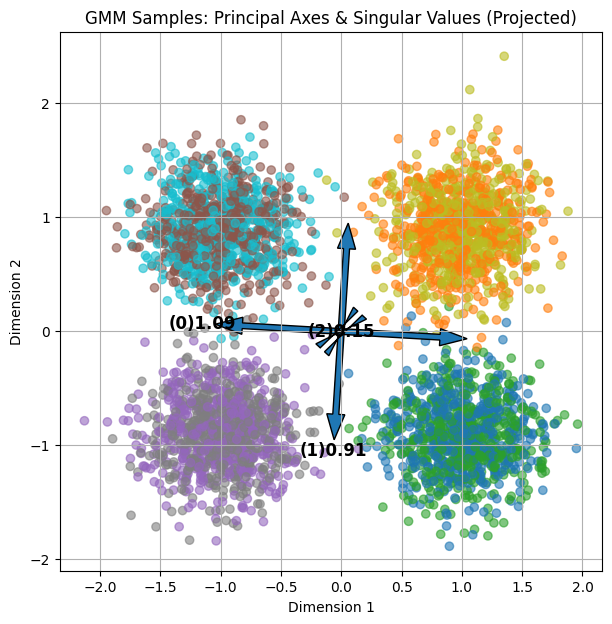

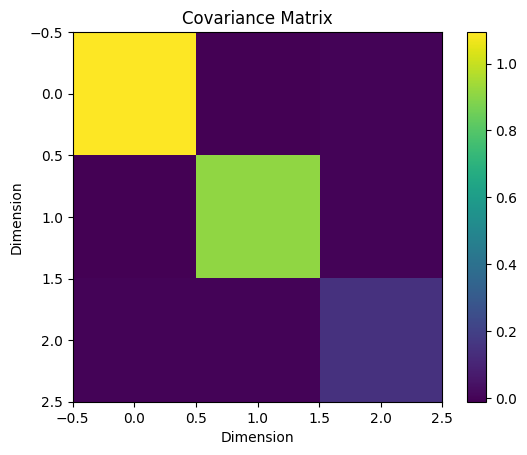

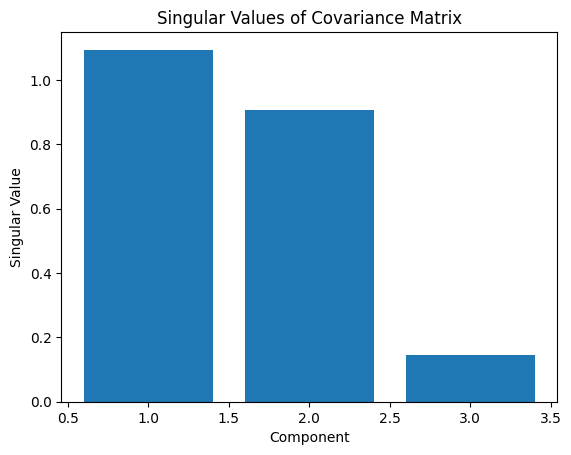

In [55]:
plot_2d_projection_with_principal_axes(data_test, labels_test, dim_x=0, dim_y=1)

/tmp/ipykernel_482944/3480435759.py:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


<Axes: title={'center': 'Distribution of Language A with 95% Confidence'}, xlabel='Backness', ylabel='Height'>

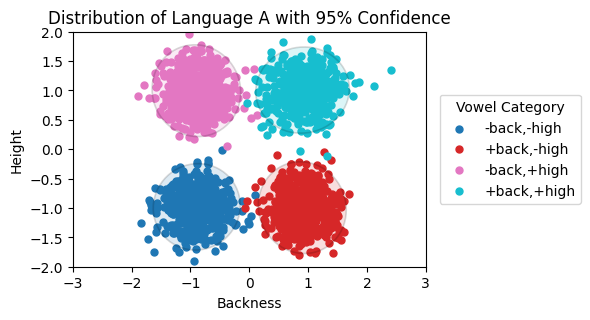

In [56]:
["i", "ɯ", "ɛ", "ʌ", "y", "u", "œ", "ɔ"]
label_map_A = {
    'i': '-back,+high', 'ɯ': '+back,+high', 'ɛ': '-back,-high', 'ʌ': '+back,-high'
}
target_tokens = ["ɛ", "ʌ", "i", "ɯ"]
data_selected, labels_selected, _ = select_tokens(data_test, labels_test, target_tokens=target_tokens)
# plot_tokens_2d(data_selected, labels_selected, dim_x=0, dim_y=1)
plot_with_conf_ellipses(data_selected, labels_selected, 
                        dims=(1,0),dim_names=("Backness", "Height"), language="A", 
                        label_map=label_map_A, label_list=target_tokens, save_path="./writing_plot/language_A_distribution.pdf")

/tmp/ipykernel_482944/3480435759.py:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


<Axes: title={'center': 'Distribution of Language B with 95% Confidence'}, xlabel='Backness', ylabel='Rounding'>

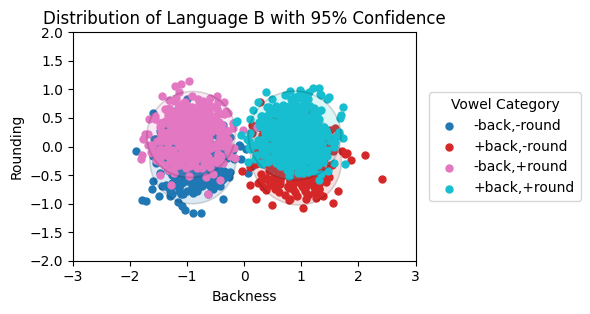

In [57]:
["i", "ɯ", "ɛ", "ʌ", "y", "u", "œ", "ɔ"]
label_map_B = {
    'i': '-back,-round', 'ɯ': '+back,-round', 
    "y": '-back,+round', "u": '+back,+round', 
}
target_tokens = ["i", "ɯ", "y", "u"]
data_selected, labels_selected, _ = select_tokens(data_test, labels_test, target_tokens=target_tokens)
# plot_tokens_2d(data_selected, labels_selected, dim_x=0, dim_y=1)
plot_with_conf_ellipses(data_selected, labels_selected, 
                        dims=(1,2),dim_names=("Backness", "Rounding"), language="B", 
                        label_map=label_map_B, label_list=target_tokens, save_path="./writing_plot/language_B_distribution.pdf")

#### Training

In [58]:
# set parameters
num_samples = sum(sizes_train)
epochs = 10000
lr = 0.01
reg_param = 0.1
var_param = 0.0
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()
z_data = torch.from_numpy(np.array(
        [
        [1.0, 0.0, 0.0],
        [-1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, -1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.0, 0.0, -1.0],
        [1.0, 0.0, 0.0],
        [-1.0, 0.0, 0.0]
    ]
)).float()  # for testing
z_labels = np.array(
    [
        '1+', '1-',
        '2+', '2-',
        '3+', '3-',
        '4+', '4-'
    ]
)

# set seed
np.random.seed(123)
torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):
t = 1
laeModel = LinearAutoEncoder()
laeModel.train(input_data, None, input_dim=3, 
                n_epoch=epochs, hidden_dim=hidden_dim, 
                learning_rate=lr, reg_param=reg[t], 
                noise='Gaussian', noise_scale=var[t], verbose=True, 
                Y=torch.from_numpy(data_test).float(), 
                Y_val=labels_test, 
                Z=z_data,
                Z_val=z_labels)
recorded_models.append(laeModel)

iteration:  0 training loss:  tensor(1.0384, device='cuda:0')
iteration:  100 training loss:  tensor(1.0384, device='cuda:0')
iteration:  200 training loss:  tensor(1.0384, device='cuda:0')
iteration:  300 training loss:  tensor(1.0384, device='cuda:0')
iteration:  400 training loss:  tensor(1.0384, device='cuda:0')
iteration:  500 training loss:  tensor(1.0383, device='cuda:0')
iteration:  600 training loss:  tensor(1.0374, device='cuda:0')
iteration:  700 training loss:  tensor(1.0311, device='cuda:0')
iteration:  800 training loss:  tensor(0.9907, device='cuda:0')
iteration:  900 training loss:  tensor(0.8147, device='cuda:0')
iteration:  1000 training loss:  tensor(0.6105, device='cuda:0')
iteration:  1100 training loss:  tensor(0.5482, device='cuda:0')
iteration:  1200 training loss:  tensor(0.4378, device='cuda:0')
iteration:  1300 training loss:  tensor(0.2933, device='cuda:0')
iteration:  1400 training loss:  tensor(0.2471, device='cuda:0')
iteration:  1500 training loss:  tens

Check how different PC dimensions work

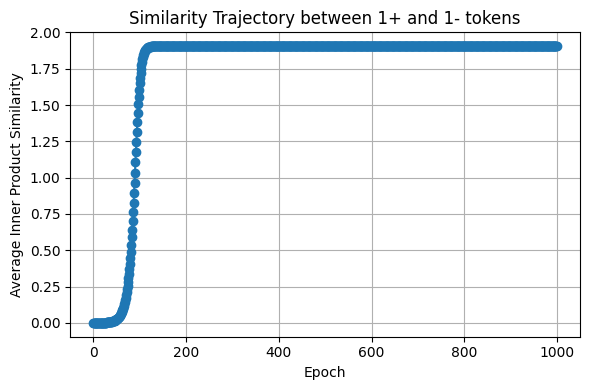

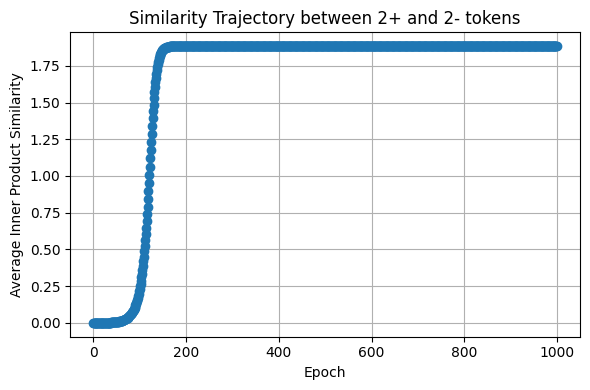

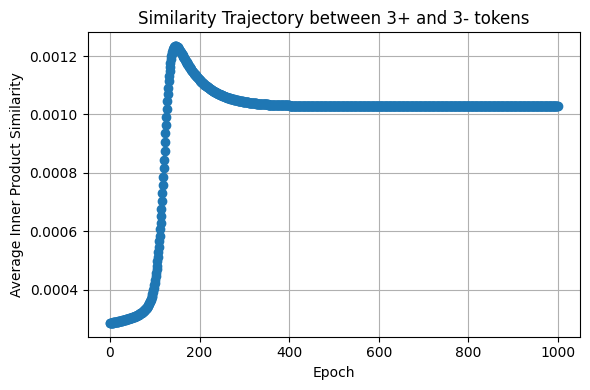

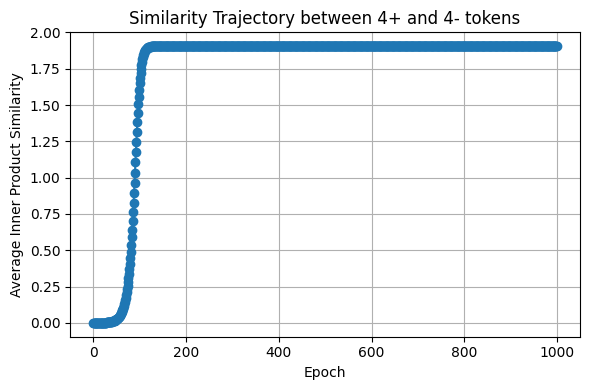

In [59]:
similarity_curves = {}
for contrast_pair in [("1+", "1-"), ("2+", "2-"), ("3+", "3-"), ("4+", "4-")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["z_testing_activations"], z_labels, label_a=label_a, label_b=label_b, 
                                                calculator=average_euclidean_distance)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Beautified Visualization

In [60]:
color_map = {
    "height": "blue", 
    "backness": "orange", 
    "rounding": "green"
}

('y', 'œ'): (1000,)
('œ', 'ɔ'): (1000,)
('œ', 'ɛ'): (1000,)


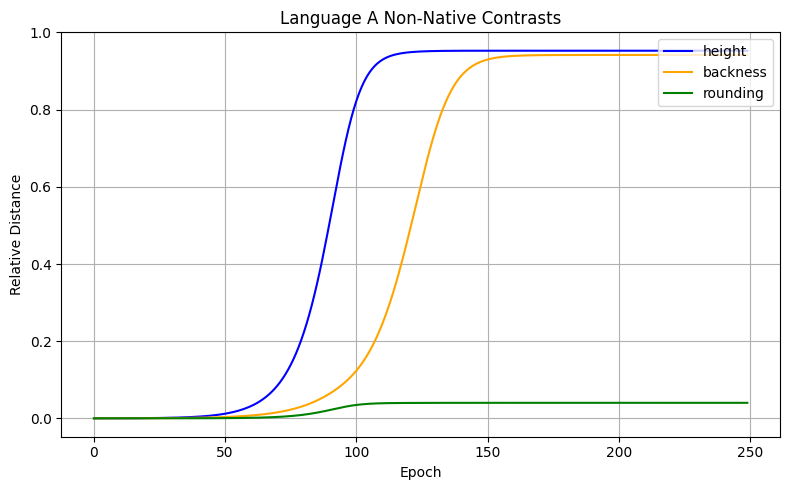

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Define the contrasts you want to include (native + others)
contrast_list = [("y", "œ"), ("œ", "ɔ"), ("œ", "ɛ")] # ("i", "ɯ"), ("i", "ɛ")
# contrast_names = {("œ", "ɛ"):"non-native:rounding", 
#                   ("œ", "ɔ"):"non-native:backness", 
#                   ("y", "œ"):"non-native:height", 
#                   ("i", "ɯ"):"native:backness", 
#                   ("i", "ɛ"):"native:height"}

contrast_names = {("œ", "ɛ"):"rounding", 
                  ("œ", "ɔ"):"backness", 
                  ("y", "œ"):"height", 
                  ("i", "ɯ"):"backness", 
                  ("i", "ɛ"):"height"}

# Initialize storage
raw_curves = {}  # maps (label_a, label_b) → np.array of distances per epoch

# Iterate over contrasts and compute full trajectories
for label_a, label_b in contrast_list:
    similarity_curve = similarity_trajectory_normalized(
        recorded_models[0].history["testing_activations"],
        data_test, 
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    raw_curves[(label_a, label_b)] = np.array(similarity_curve)

# Verify shape
for pair, curve in raw_curves.items():
    print(f"{pair}: {curve.shape}")

# (Optional quick check)
plt.figure(figsize=(8,5))
for (label_a, label_b), curve in raw_curves.items():
    # plt.plot(curve, label=f"{label_a} vs {label_b}")
    plt.plot(curve[:250], 
             label=f"{contrast_names[(label_a, label_b)]}", 
            color=color_map[contrast_names[(label_a, label_b)]])
plt.xlabel("Epoch")
plt.ylabel("Relative Distance")
plt.title("Language A Non-Native Contrasts")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./writing_plot/sim_curve_A_nonnative.pdf")
plt.show()


('i', 'ɛ'): (1000,)
('i', 'ɯ'): (1000,)


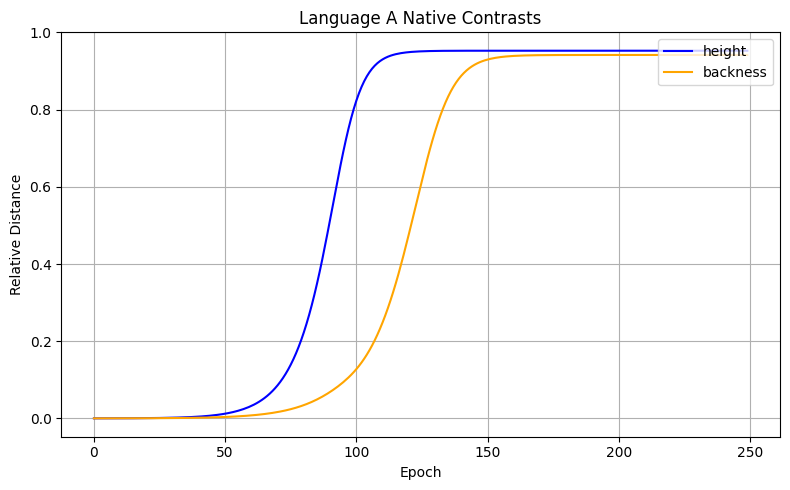

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Define the contrasts you want to include (native + others)
contrast_list = [("i", "ɛ"), ("i", "ɯ")] # ("i", "ɯ"), ("i", "y")
# contrast_names = {("œ", "ɛ"):"non-native:rounding", 
#                   ("œ", "ɔ"):"non-native:backness", 
#                   ("y", "œ"):"non-native:height", 
#                   ("i", "ɯ"):"native:backness", 
#                   ("i", "ɛ"):"native:height"}

contrast_names = {("œ", "ɛ"):"rounding", 
                  ("œ", "ɔ"):"backness", 
                  ("y", "œ"):"height", 
                  ("i", "ɯ"):"backness", 
                  ("i", "ɛ"):"height", 
                  ("i", "y"):"rounding"}

# Initialize storage
raw_curves = {}  # maps (label_a, label_b) → np.array of distances per epoch

# Iterate over contrasts and compute full trajectories
for label_a, label_b in contrast_list:
    similarity_curve = similarity_trajectory_normalized(
        recorded_models[0].history["testing_activations"],
        data_test, 
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    raw_curves[(label_a, label_b)] = np.array(similarity_curve)

# Verify shape
for pair, curve in raw_curves.items():
    print(f"{pair}: {curve.shape}")

# (Optional quick check)
plt.figure(figsize=(8,5))
for (label_a, label_b), curve in raw_curves.items():
    # plt.plot(curve, label=f"{label_a} vs {label_b}")
    plt.plot(curve[:250], 
             label=f"{contrast_names[(label_a, label_b)]}", 
            color=color_map[contrast_names[(label_a, label_b)]])
plt.xlabel("Epoch")
plt.ylabel("Relative Distance")
plt.title("Language A Native Contrasts")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./writing_plot/sim_curve_A_native.pdf")
plt.show()


### Case 2: One Large Contrast One Small Contrast

#### Data Generation and Visualization

In [45]:
# training means and shared std
heightTr, heightTe, backTr, backTe, roundTr, roundTe = 0.0, 1.0, 0.9, 0.9, -0.2, -0.2
means_train = [
    np.array([heightTr, -backTr, roundTr]),  # /i/
    np.array([heightTr, backTr, roundTr]),  # /ɯ/
    np.array([heightTr, -backTr, -roundTr]),  # /y/
    np.array([heightTr, backTr, -roundTr]),  # /u/
]
var_strength = 0.1  # same in all dimensions
vars_train = [var_strength] * len(means_train)
sizes_train = [1000 // len(means_train)] * len(means_train)  # for example
tags_train = ["i", "ɯ", "y", "u"] 

# means_test = [
#     np.array([1.0, -0.9, 0.2, 0.0]),  # /i/
#     np.array([1.0, 0.9, 0.2, 0.0]),  # /ɯ/
#     np.array([-1.0, -0.9, 0.2, 0.0]),  # /ɛ/
#     np.array([-1.0, 0.9, 0.2, 0.0]),  # /ʌ/
#     np.array([1.0, -0.9, -0.2, 0.0]),  # /y/
#     np.array([1.0, 0.9, -0.2, 0.0]),  # /u/
#     np.array([-1.0, -0.9, -0.2, 0.0]),  # /œ/
#     np.array([-1.0, 0.9, -0.2, 0.0]),  # /ɔ/
# ]
means_test = [
    np.array([heightTe, -backTe, roundTe]),  # /i/
    np.array([heightTe, backTe, roundTe]),  # /ɯ/
    np.array([-heightTe, -backTe, roundTe]),  # /ɛ/
    np.array([-heightTe, backTe, roundTe]),  # /ʌ/
    np.array([heightTe, -backTe, -roundTe]),  # /y/
    np.array([heightTe, backTe, -roundTe]),  # /u/
    np.array([-heightTe, -backTe, -roundTe]),  # /œ/
    np.array([-heightTe, backTe, -roundTe]),  # /ɔ/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [500] * len(means_test)  # for example
tags_test = ["i", "ɯ", "ɛ", "ʌ", "y", "u", "œ", "ɔ"]

data_train, labels_train = generate_gmm_data(d=3, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=3, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

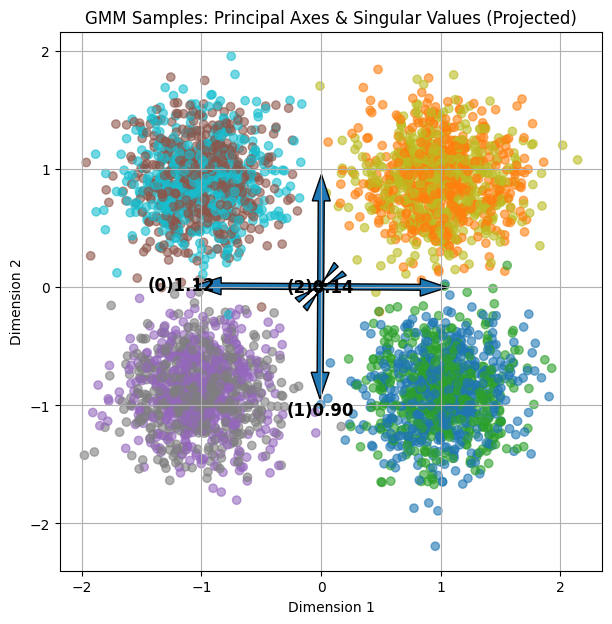

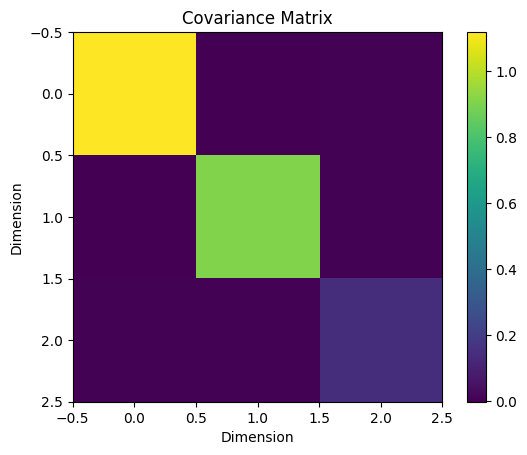

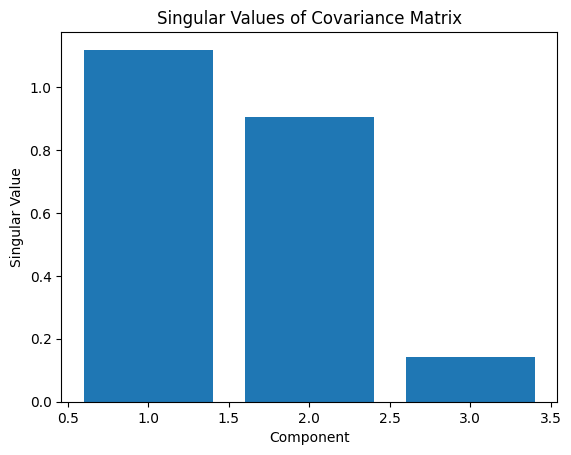

In [46]:
plot_2d_projection_with_principal_axes(data_test, labels_test, dim_x=0, dim_y=1)

#### Training

In [47]:
# set parameters
num_samples = sum(sizes_train)
epochs = 10000
lr = 0.05
reg_param = 0.1
var_param = 0.0
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()
z_data = torch.from_numpy(np.array(
        [
        [1.0, 0.0, 0.0],
        [-1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, -1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.0, 0.0, -1.0],
        [1.0, 0.0, 0.0],
        [-1.0, 0.0, 0.0]
    ]
)).float()  # for testing
z_labels = np.array(
    [
        '1+', '1-',
        '2+', '2-',
        '3+', '3-',
        '4+', '4-'
    ]
)

# set seed
np.random.seed(123)
torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):
t = 1
laeModel = LinearAutoEncoder()
laeModel.train(input_data, None, input_dim=3, 
                n_epoch=epochs, hidden_dim=hidden_dim, 
                learning_rate=lr, reg_param=reg[t], 
                noise='Gaussian', noise_scale=var[t], verbose=True, 
                Y=torch.from_numpy(data_test).float(), 
                Y_val=labels_test, 
                Z=z_data,
                Z_val=z_labels)
recorded_models.append(laeModel)

iteration:  0 training loss:  tensor(0.5637, device='cuda:0')
iteration:  100 training loss:  tensor(0.5637, device='cuda:0')
iteration:  200 training loss:  tensor(0.5383, device='cuda:0')
iteration:  300 training loss:  tensor(0.2116, device='cuda:0')
iteration:  400 training loss:  tensor(0.2115, device='cuda:0')
iteration:  500 training loss:  tensor(0.2115, device='cuda:0')
iteration:  600 training loss:  tensor(0.2115, device='cuda:0')
iteration:  700 training loss:  tensor(0.2115, device='cuda:0')
iteration:  800 training loss:  tensor(0.2115, device='cuda:0')
iteration:  900 training loss:  tensor(0.2115, device='cuda:0')
iteration:  1000 training loss:  tensor(0.2115, device='cuda:0')
iteration:  1100 training loss:  tensor(0.2115, device='cuda:0')
iteration:  1200 training loss:  tensor(0.2115, device='cuda:0')
iteration:  1300 training loss:  tensor(0.2115, device='cuda:0')
iteration:  1400 training loss:  tensor(0.2115, device='cuda:0')
iteration:  1500 training loss:  tens

Check how different PC dimensions work

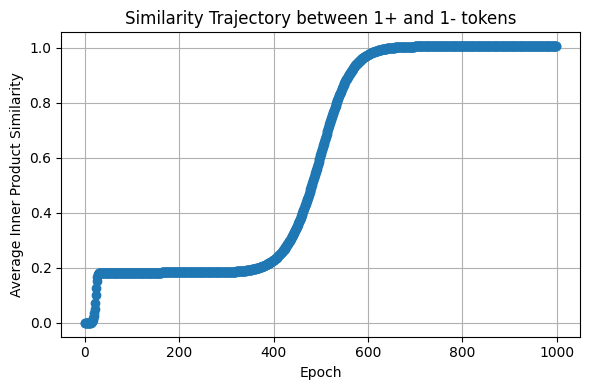

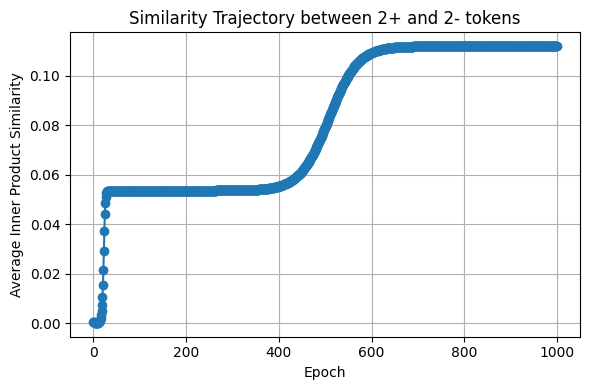

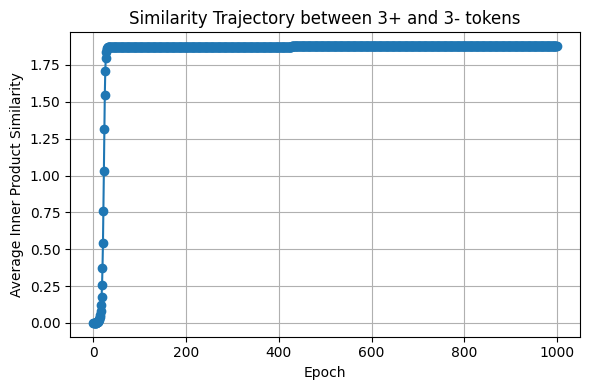

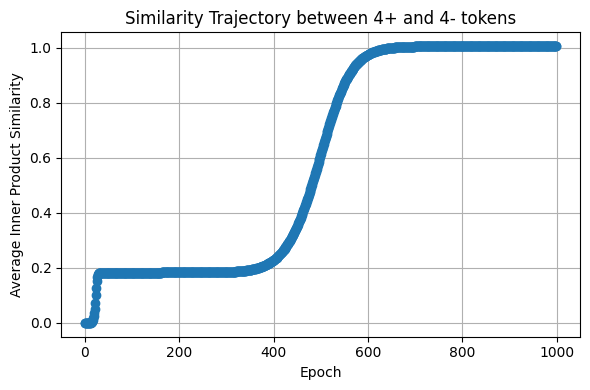

In [48]:
similarity_curves = {}
for contrast_pair in [("1+", "1-"), ("2+", "2-"), ("3+", "3-"), ("4+", "4-")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["z_testing_activations"], z_labels, label_a=label_a, label_b=label_b, 
                                                calculator=average_euclidean_distance)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Beautified Visualization

In [49]:
color_map = {
    "height": "blue", 
    "backness": "orange", 
    "rounding": "green"
}

('y', 'œ'): (1000,)
('œ', 'ɔ'): (1000,)
('œ', 'ɛ'): (1000,)


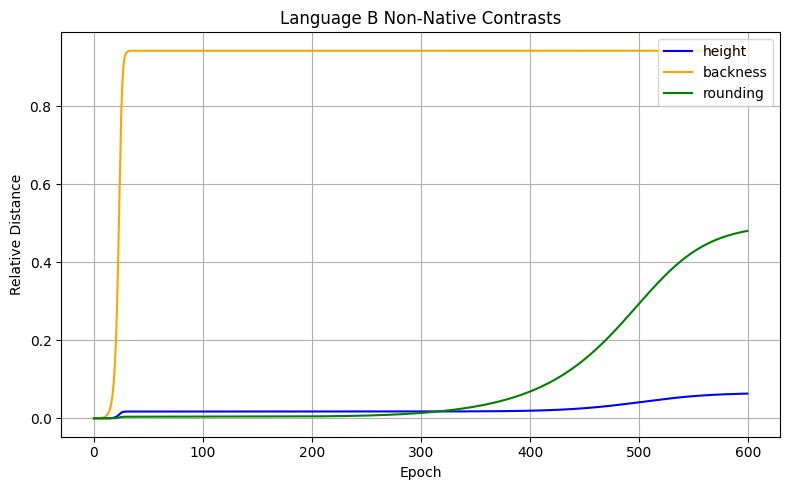

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Define the contrasts you want to include (native + others)
contrast_list = [("y", "œ"), ("œ", "ɔ"), ("œ", "ɛ")] # ("i", "ɯ"), ("i", "ɛ")
# contrast_names = {("œ", "ɛ"):"non-native:rounding", 
#                   ("œ", "ɔ"):"non-native:backness", 
#                   ("y", "œ"):"non-native:height", 
#                   ("i", "ɯ"):"native:backness", 
#                   ("i", "ɛ"):"native:height"}

contrast_names = {("œ", "ɛ"):"rounding", 
                  ("œ", "ɔ"):"backness", 
                  ("y", "œ"):"height", 
                  ("i", "ɯ"):"backness", 
                  ("i", "ɛ"):"height"}

# Initialize storage
raw_curves = {}  # maps (label_a, label_b) → np.array of distances per epoch

# Iterate over contrasts and compute full trajectories
for label_a, label_b in contrast_list:
    similarity_curve = similarity_trajectory_normalized(
        recorded_models[0].history["testing_activations"],
        data_test, 
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    raw_curves[(label_a, label_b)] = np.array(similarity_curve)

# Verify shape
for pair, curve in raw_curves.items():
    print(f"{pair}: {curve.shape}")

# (Optional quick check)
plt.figure(figsize=(8,5))
for (label_a, label_b), curve in raw_curves.items():
    # plt.plot(curve, label=f"{label_a} vs {label_b}")
    plt.plot(curve[:600], 
             label=f"{contrast_names[(label_a, label_b)]}", 
            color=color_map[contrast_names[(label_a, label_b)]])
plt.xlabel("Epoch")
plt.ylabel("Relative Distance")
plt.title("Language B Non-Native Contrasts")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./writing_plot/sim_curve_B_nonnative.pdf")
plt.show()


('i', 'ɯ'): (1000,)
('i', 'y'): (1000,)


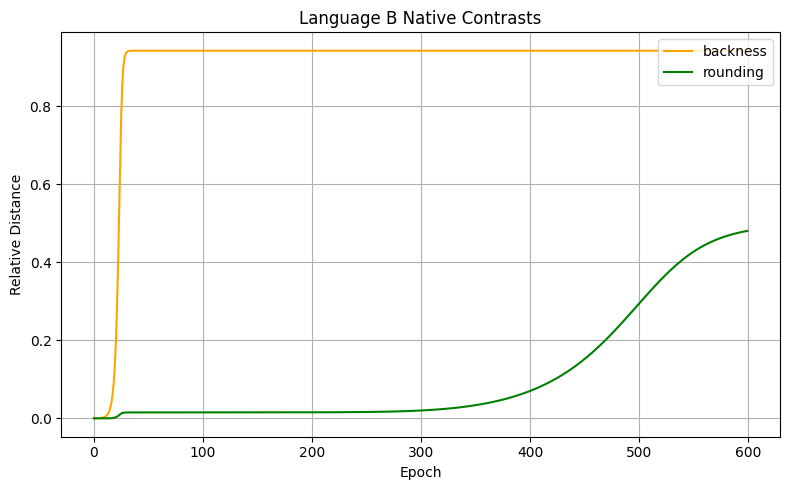

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define the contrasts you want to include (native + others)
contrast_list = [("i", "ɯ"), ("i", "y")] # ("i", "ɯ"), ("i", "y")
# contrast_names = {("œ", "ɛ"):"non-native:rounding", 
#                   ("œ", "ɔ"):"non-native:backness", 
#                   ("y", "œ"):"non-native:height", 
#                   ("i", "ɯ"):"native:backness", 
#                   ("i", "ɛ"):"native:height"}

contrast_names = {("œ", "ɛ"):"rounding", 
                  ("œ", "ɔ"):"backness", 
                  ("y", "œ"):"height", 
                  ("i", "ɯ"):"backness", 
                  ("i", "ɛ"):"height", 
                  ("i", "y"):"rounding"}

# Initialize storage
raw_curves = {}  # maps (label_a, label_b) → np.array of distances per epoch

# Iterate over contrasts and compute full trajectories
for label_a, label_b in contrast_list:
    similarity_curve = similarity_trajectory_normalized(
        recorded_models[0].history["testing_activations"],
        data_test, 
        labels_test,
        label_a=label_a,
        label_b=label_b,
        calculator=average_euclidean_distance
    )
    raw_curves[(label_a, label_b)] = np.array(similarity_curve)

# Verify shape
for pair, curve in raw_curves.items():
    print(f"{pair}: {curve.shape}")

# (Optional quick check)
plt.figure(figsize=(8,5))
for (label_a, label_b), curve in raw_curves.items():
    # plt.plot(curve, label=f"{label_a} vs {label_b}")
    plt.plot(curve[:600], 
             label=f"{contrast_names[(label_a, label_b)]}", 
            color=color_map[contrast_names[(label_a, label_b)]])
plt.xlabel("Epoch")
plt.ylabel("Relative Distance")
plt.title("Language B Native Contrasts")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./writing_plot/sim_curve_B_native.pdf")
plt.show()


#### End of Organized Simulations